In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import sys
sys.path.append('custom_modules')

import Data_processing as dp

from IPython.display import display
from matplotlib import ticker
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Reshape, Input, Dense, Flatten, Conv2D, Dropout, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, concatenate, BatchNormalization

### Константы для путей к файлам

In [2]:
# Пути к обработанным данным
# Пути к X части выборки с массивами в каждой ячейке
path_to_array_like_X_data = 'data/Prepared data/Run1/X_data_array_like.xlsx'
# Пути к Y части выборки
path_to_Y_data = 'data/Prepared data/Run1/Y_data(binary_classification).xlsx'


### Константы для обработки данных

In [3]:
PREP_image_size = 64
PREP_crop_step = 6

In [4]:
# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)

# Подготовка данных

In [5]:
# загрузка данных из файлов
X_dict = dict()
Y_dict = dict()

X_dict['df'] =  dp.get_array_like_X_df(path_to_array_like_X_data)
Y_dict['df'] =  dp.get_Y_df(path_to_Y_data)

#X_dict['df'] = pd.concat([X_dict['df'].iloc[:,200:],X_dict['df'].iloc[:,:200]],axis=1,ignore_index=True)
#Y_dict['df'] = pd.concat([Y_dict['df'].iloc[:,200:],Y_dict['df'].iloc[:,:200]],axis=1,ignore_index=True)

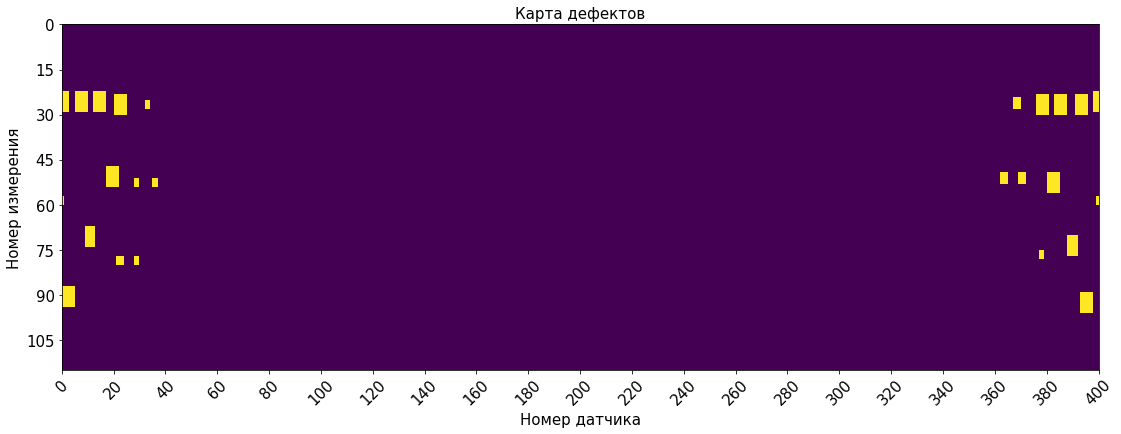

In [6]:
# карта дефектов для считанного файла
fig, axes = plt.subplots()

fig.set_figwidth(18)
fig.set_figheight(6)

axes.pcolormesh(Y_dict['df'])
axes.invert_yaxis()

axes.set_xlabel('Номер датчика', fontsize=15) 
axes.set_ylabel('Номер измерения', fontsize=15) 
axes.set_title(f'Карта дефектов', fontsize=15) 

#  Устанавливаем интервал основных делений: 
axes.xaxis.set_major_locator(ticker.MultipleLocator(20)) 
axes.yaxis.set_major_locator(ticker.MultipleLocator(15)) 
 
#  Устанавливаем форматирование чисел основных делений: 
axes.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
axes.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.d'))

#  Устанавливаем форматирование делений: 
axes.xaxis.set_tick_params(which = 'major', labelsize = 15, labelrotation = 45) 
axes.yaxis.set_tick_params(which = 'major', labelsize = 15) 

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.2)
plt.show()

In [7]:
# добавление строк в датафреймы
print('||||||||||| X df preprocessing |||||||||||')
print('Original df size: ', X_dict['df'] .shape)
X_dict['df'] = pd.concat([X_dict['df'],X_dict['df'].iloc[:,:64]],axis=1,ignore_index=True)
X_dict['df'] = pd.concat([X_dict['df'],X_dict['df'].iloc[:64,:]],axis=0,ignore_index=True)
print('Result df size: ', X_dict['df'] .shape)
X_dict['df'] = dp.reshape_df_for_future_crops(X_dict['df'], 
                                                        PREP_image_size, 
                                                        PREP_crop_step)

print('||||||||||| Y df preprocessing |||||||||||')
print('Original df size: ', Y_dict['df'].shape)
Y_dict['df'] = pd.concat([Y_dict['df'],Y_dict['df'].iloc[:,:64]],axis=1,ignore_index=True)
Y_dict['df'] = pd.concat([Y_dict['df'],Y_dict['df'].iloc[:64,:]],axis=0,ignore_index=True)
print('Original df size: ', Y_dict['df'].shape)
Y_dict['df'] = dp.reshape_df_for_future_crops(Y_dict['df'], 
                                                        PREP_image_size, 
                                                        PREP_crop_step)

print('\n')

||||||||||| X df preprocessing |||||||||||
Original df size:  (115, 400)
Result df size:  (179, 464)
||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (179, 464)
Crop windows height/width:  64
Crop windows step across rows and cols:  6
New df shape:  (184, 466)
||||||||||||||||||

||||||||||| Y df preprocessing |||||||||||
Original df size:  (115, 400)
Original df size:  (179, 464)
||||||||||||||||||
Df reshaping for exact splitting with crop_size
Original df size:  (179, 464)
Crop windows height/width:  64
Crop windows step across rows and cols:  6
New df shape:  (184, 466)
||||||||||||||||||





### Константы для обработки данных

In [8]:
PREP_df_cols = Y_dict['df'].shape[1]
PREP_df_rows = Y_dict['df'].shape[0]

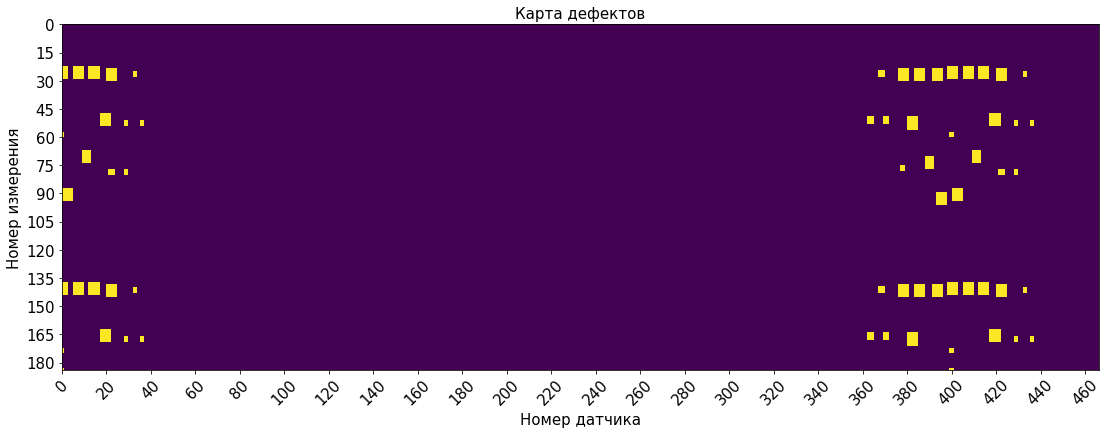

In [9]:
# как выглядит карта дефектов после первичного расширения
fig, axes = plt.subplots()

fig.set_figwidth(18)
fig.set_figheight(6)

axes.pcolormesh(Y_dict['df'])
axes.invert_yaxis()
axes.set_xlabel('Номер датчика', fontsize=15) 
axes.set_ylabel('Номер измерения', fontsize=15) 
axes.set_title(f'Карта дефектов', fontsize=15) 

#  Устанавливаем интервал основных делений: 
axes.xaxis.set_major_locator(ticker.MultipleLocator(20)) 
axes.yaxis.set_major_locator(ticker.MultipleLocator(15)) 
 
#  Устанавливаем форматирование чисел основных делений: 
axes.xaxis.set_major_formatter(ticker.FormatStrFormatter('%.d')) 
axes.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.d'))

#  Устанавливаем форматирование делений: 
axes.xaxis.set_tick_params(which = 'major', labelsize = 15, labelrotation = 45) 
axes.yaxis.set_tick_params(which = 'major', labelsize = 15) 

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.2)
plt.show()

In [10]:
# запишем в словарь numpy array полученные из df

print('||||||||||| X df preprocessing |||||||||||')
x_time_temp, \
x_amp_temp = dp.reshape_X_df_to_image_like_numpy(X_dict['df'], 
                                                    PREP_image_size, 
                                                    PREP_crop_step)
X_dict['X_time_all'] = x_time_temp.astype('float32')
X_dict['X_amp_all'] = x_amp_temp.astype('float32')

X_dict.pop('df',0)

print('||||||||||| Y df preprocessing |||||||||||')
y_temp = dp.reshape_Y_df_to_image_like_numpy(Y_dict['df'], 
                                             PREP_image_size, 
                                             PREP_crop_step)
Y_dict['Y_mask_all'] = y_temp.astype('int8')

Y_dict.pop('df',0)

print('\n')
    
    

||||||||||| X df preprocessing |||||||||||
||||||||||||||||||
X df reshaping to 4D
Original df size:  (184, 466)
Crop windows height/width:  64
Crop windows step across rows and cols:  6
New X_time shape:  (1428, 64, 64, 32)
New X_amp shape:  (1428, 64, 64, 32)
||||||||||||||||||

||||||||||| Y df preprocessing |||||||||||
||||||||||||||||||
Y df reshaping to 3D
Original df size:  (184, 466)
Crop windows height/width:  64
Crop windows step across rows and cols:  6
New numpy shape:  (1428, 64, 64, 1)
||||||||||||||||||





In [11]:
print('||||||||||||||||||||||||||||')
print('\n||||||||||| X data |||||||||||')
print(f'Для \"X\" выборки считано ', X_dict.keys())

print('\n||||||||||| Y data |||||||||||')        
print(f'Для \"Y\" выборки считано ', Y_dict.keys())

||||||||||||||||||||||||||||

||||||||||| X data |||||||||||
Для "X" выборки считано  dict_keys(['X_time_all', 'X_amp_all'])

||||||||||| Y data |||||||||||
Для "Y" выборки считано  dict_keys(['Y_mask_all'])


In [12]:
# обработка данных
print('||||||||||| X df preprocessing |||||||||||')

(X_time_def, X_time_non_def), \
(X_amp_def, X_amp_non_def), \
(Y_mask_def, Y_mask_non_def), \
(Y_binary_def, Y_binary_non_def) = dp.preprocess_data(X_dict['X_time_all'], 
                                                            X_dict['X_amp_all'], 
                                                            Y_dict['Y_mask_all'],
                                                            PREP_image_size)

X_dict['X_time_def'] = X_time_def
X_dict['X_time_non_def'] = X_time_non_def

X_dict['X_amp_def'] = X_amp_def
X_dict['X_amp_non_def'] = X_amp_non_def

Y_dict['Y_mask_def'] = Y_mask_def
Y_dict['Y_mask_non_def'] = Y_mask_non_def

Y_dict['Y_binary_def'] = Y_binary_def
Y_dict['Y_binary_non_def'] = Y_binary_non_def

||||||||||| X df preprocessing |||||||||||
||||||||||||||||||
Data preprocessing
Orig X_time shape:  (1428, 64, 64, 32)
Orig X_amp shape:  (1428, 64, 64, 32)
Orig Y_mask shape:  (1428, 64, 64, 1)
||||||||||||||||||
Data standartization
X_time_max: 44.5
X_amp_max: 62.992000579833984

X_time_max after standartization: 1.0
X_time_min after standartization: 0.0

X_amp_max after standartization: 1.0
X_amp_min after standartization: -0.9837439060211182
||||||||||||||||||

||||||||||||||||||
Data with and witout defects splitting
||||||||||||||||||
Defects nums calculating
Для карт высотой и шириной в 64
и общим кличеством: 1428
дефекты присутствуеют на 496 картах
||||||||||||||||||

X_time_def shape:  (496, 64, 64, 32)
X_time_non_def shape:  (932, 64, 64, 32)

X_amp_def shape:  (496, 64, 64, 32)
X_amp_non_def shape:  (932, 64, 64, 32)

Y_mask_def shape:  (496, 64, 64, 1)
Y_mask_non_def shape:  (932, 64, 64, 1)

Y_binary_def shape:  (496,)
Y_binary_non_def shape:  (932,)
||||||||||||||||||

|

In [13]:
# очистка памяти от лишнего

X_dict.pop('X_time_all',0)
X_dict.pop('X_amp_all',0)
Y_dict.pop('Y_mask_all',0)
print()

In [14]:
print('|||||||||||||| X dataset ||||||||||||||||')
for key in X_dict.keys():
    print(f"{key}.shape: ", X_dict[key].shape)

print('\n|||||||||||||| Y dataset ||||||||||||||||')
for key in Y_dict.keys():
    print(f"{key}.shape: ", Y_dict[key].shape)

|||||||||||||| X dataset ||||||||||||||||
X_time_def.shape:  (496, 64, 64, 32)
X_time_non_def.shape:  (932, 64, 64, 32)
X_amp_def.shape:  (496, 64, 64, 32)
X_amp_non_def.shape:  (932, 64, 64, 32)

|||||||||||||| Y dataset ||||||||||||||||
Y_mask_def.shape:  (496, 64, 64, 1)
Y_mask_non_def.shape:  (932, 64, 64, 1)
Y_binary_def.shape:  (496,)
Y_binary_non_def.shape:  (932,)


In [ ]:
# аугментация
print('|||||||||||||| X dataset ||||||||||||||||')
for key in X_dict.keys():
    X_dict[key] = dp.augment_data(X_dict[key]) 

print('\n|||||||||||||| Y dataset ||||||||||||||||')
print(f"|||||||||||||| dataset part: Y_binary_def||||||||||||||||")
print(f'Orig arr shape: {Y_dict["Y_binary_def"].shape}')
Y_dict['Y_binary_def'] = np.ones(X_dict['X_time_def'].shape[0])
print(f'Result arr shape: {Y_dict["Y_binary_def"].shape}')

print(f"|||||||||||||| dataset part: Y_binary_non_def||||||||||||||||")
print(f'Orig arr shape: {Y_dict["Y_binary_non_def"].shape}')
Y_dict['Y_binary_non_def'] = np.zeros(X_dict['X_time_non_def'].shape[0])
print(f'Result arr shape: {Y_dict["Y_binary_non_def"].shape}')    

In [15]:
# что имеем перед тем как объеденить данные в тестовые
print('|||||||||||||| X dataset ||||||||||||||||')
for key in X_dict.keys():
    print(f"{key}.shape: ", X_dict[key].shape)

print('\n|||||||||||||| Y dataset ||||||||||||||||')
for key in Y_dict.keys():
    print(f"{key}.shape: ", Y_dict[key].shape)

|||||||||||||| X dataset ||||||||||||||||
X_time_def.shape:  (496, 64, 64, 32)
X_time_non_def.shape:  (932, 64, 64, 32)
X_amp_def.shape:  (496, 64, 64, 32)
X_amp_non_def.shape:  (932, 64, 64, 32)

|||||||||||||| Y dataset ||||||||||||||||
Y_mask_def.shape:  (496, 64, 64, 1)
Y_mask_non_def.shape:  (932, 64, 64, 1)
Y_binary_def.shape:  (496,)
Y_binary_non_def.shape:  (932,)


In [16]:
# объединение данных в тестовую выборку
X_time_test = np.concatenate([X_dict['X_time_def'],X_dict['X_time_non_def']],
                                                                     axis=0)                           
X_dict.pop('X_time_def',0)
X_dict.pop('X_time_non_def',0)


X_amp_test = np.concatenate([X_dict['X_amp_def'],X_dict['X_amp_non_def']],
                                                                   axis=0)
X_dict.pop('X_amp_def',0)
X_dict.pop('X_amp_non_def',0)


Y_mask_test = np.concatenate([Y_dict['Y_mask_def'],Y_dict['Y_mask_non_def']],
                                                                         axis=0)
Y_dict.pop('Y_mask_def',0)
Y_dict.pop('Y_mask_non_def',0)


Y_binary_test = np.concatenate([Y_dict['Y_binary_def'],Y_dict['Y_binary_non_def']],
                                                                         axis=0)
Y_dict.pop('Y_binary_def',0)
Y_dict.pop('Y_binary_non_def',0)
print()

In [17]:
# очистка памяти от лишнего        
X_dict.clear()
Y_dict.clear()

In [18]:
# сколько получилось тестовых данных
print('X_time_test.shape: ', X_time_test.shape)
print('X_amp_test.shape: ', X_amp_test.shape)
print('Y_mask_test.shape', Y_mask_test.shape)
print('Y_binary_test.shape', Y_binary_test.shape)
print('\n')

X_time_test.shape:  (1428, 64, 64, 32)
X_amp_test.shape:  (1428, 64, 64, 32)
Y_mask_test.shape (1428, 64, 64, 1)
Y_binary_test.shape (1428,)




# CNN с 2 входами по времени и амплитуде

In [19]:
# загрузка модели
model = keras.models.load_model('Networks//CNN//NetWork_(64x32+64x32)_to(1)_(test_0dot0366)_ver_10.h5')

In [20]:
# тест модели
model.evaluate([X_time_test,X_amp_test], Y_binary_test, batch_size = 1)

1428/1428 [==============================] - 40s 28ms/step - loss: 0.0117


0.011659838259220123